### Standard Star
This notebook is not part of the main series of notebooks, but it was used to create a csv with the values need to calibrate our intensities. Our work here is based on a notebook made by Scott Trager available [here](https://blaauwobserverknowledgebase.readthedocs.io/en/latest/pm/standard-stars.html). Another part of this notebook attaches WCS coordinates to our images.

In [5]:
from astropy.io import fits
from astropy.coordinates import SkyCoord
import matplotlib.pyplot as plt
import numpy as np
import numpy.ma as ma
from photutils.background import MMMBackground, Background2D
from astropy.wcs import WCS
from astropy.table import vstack
import astropy.units as u
from photutils.aperture import SkyCircularAperture, CircularAperture, aperture_photometry
import glob

# default Gratama gain and readnoise
gain=1.4
rn=13.

# make the plots BIG
plt.rcParams['figure.figsize'] = [10,10]

data_dir = "/net/virgo01/data/users/tboersma/2025-04-30/final_images"

In [7]:
wcs_header = fits.getheader(data_dir + '/wcs.fits', 0)
wcs_keys   = [k for k in wcs_header
              if any(k.startswith(x) for x in
                     ('CTYPE','CRPIX','CRVAL','CDELT','CD','PC','CROTA'))]

for fn in glob.glob(data_dir + '/final_STARFIELD_*.fits'):
    if fn.endswith('_wcs.fits'):
        continue
    data, hdr = fits.getdata(fn, header=True)
    for k in wcs_keys:
        hdr[k] = wcs_header[k]
    out = fn.replace('.fits', '_wcs.fits')
    fits.writeto(out, data, hdr, overwrite=True)
    print("Stamped WCS:", out)

PIXSCALE = 0.5

for fn in glob.glob(data_dir + '/final_M81_*.fits'):
    if fn.endswith('_wcs.fits'):
        continue
    data, hdr = fits.getdata(fn, header=True)
    ny, nx   = data.shape
    w        = WCS(naxis=2)
    w.wcs.crpix  = [nx/2, ny/2]
    w.wcs.crval  = [148.888244, 69.065291] # m81 centre
    cd           = PIXSCALE / 3600.0
    w.wcs.cd     = np.array([[ cd,  0.0],
                             [0.0,  cd]])
    w.wcs.ctype  = ["RA---TAN", "DEC--TAN"]
    wcs_hdr      = w.to_header()

    for card, val in wcs_hdr.items():
        hdr[card] = val

    out = fn.replace('.fits', '_wcs.fits')
    fits.writeto(out, data, hdr, overwrite=True)
    print("Stamped WCS:", out)

Stamped WCS: /net/virgo01/data/users/tboersma/2025-04-30/final_images/final_STARFIELD_B*_wcs.fits
Stamped WCS: /net/virgo01/data/users/tboersma/2025-04-30/final_images/final_STARFIELD_H_alpha_wcs.fits
Stamped WCS: /net/virgo01/data/users/tboersma/2025-04-30/final_images/final_STARFIELD_R*_wcs.fits
Stamped WCS: /net/virgo01/data/users/tboersma/2025-04-30/final_images/final_STARFIELD_G*_wcs.fits
Stamped WCS: /net/virgo01/data/users/tboersma/2025-04-30/final_images/final_M81_H_alpha_wcs.fits
Stamped WCS: /net/virgo01/data/users/tboersma/2025-04-30/final_images/final_M81_G*_wcs.fits
Stamped WCS: /net/virgo01/data/users/tboersma/2025-04-30/final_images/final_M81_R*_wcs.fits
Stamped WCS: /net/virgo01/data/users/tboersma/2025-04-30/final_images/final_M81_B*_wcs.fits



Standard Star Fields

We need to calibrate our data. The first step is to photometer our standard star images and then compare these measurements to the Landolt standard star data.

In the following, I concentrate on inferring the B and V calibrations without corrections for atmospheric extinction (the airmass term). With some close reading, this notebook can be extended to cover R (and even I) band calibrations and atmospheric extinction.


In [11]:
# read in the Landolt standard star data
import astropy.units as u
from astropy.wcs import WCS
from astropy.coordinates import SkyCoord
from astropy.table import Table, vstack

landolt=Table.read(data_dir + '/landolt_all.csv',format='ascii.csv')
landolt

Name,RA,DEC,V,B-V,U-B,V-R,R-I,V-I,Nobs,Nn,e_V,e_B-V,e_U-B,e_V-R,e_R-I,e_V-I
str12,str12,str12,float64,float64,float64,float64,float64,float64,int64,int64,float64,float64,float64,float64,float64,float64
TPhe I,00:30:04.593,-46:28:10.17,14.82,0.764,0.338,0.422,0.395,0.817,25,13,0.0026,0.0032,0.0072,0.0036,0.0098,0.011
TPhe A,00:30:09.594,-46:31:28.91,14.651,0.793,0.38,0.435,0.405,0.841,29,12,0.0028,0.0046,0.0071,0.0019,0.0035,0.0032
TPhe H,00:30:09.683,-46:27:24.30,14.942,0.74,0.225,0.425,0.425,0.851,23,12,0.0029,0.0029,0.0071,0.0035,0.0077,0.0098
TPhe B,00:30:16.313,-46:27:58.57,12.334,0.405,0.156,0.262,0.271,0.535,29,17,0.0115,0.0026,0.0039,0.002,0.0019,0.0035
TPhe C,00:30:16.980,-46:32:21.40,14.376,-0.298,-1.217,-0.148,-0.211,-0.36,39,23,0.0022,0.0024,0.0043,0.0038,0.0133,0.0149
TPhe D,00:30:18.342,-46:31:19.85,13.118,1.551,1.871,0.849,0.81,1.663,37,23,0.0033,0.003,0.0118,0.0015,0.0023,0.003
TPhe E,00:30:19.768,-46:24:35.60,11.631,0.443,-0.103,0.276,0.283,0.564,38,10,0.0017,0.0013,0.0025,0.0007,0.0016,0.002
TPhe J,00:30:23.020,-46:23:51.60,13.434,1.465,1.229,0.98,1.063,2.043,28,15,0.0023,0.0043,0.0059,0.0011,0.0015,0.0011
TPhe F,00:30:49.820,-46:33:24.07,12.475,0.853,0.534,0.492,0.437,0.929,19,10,0.0008,0.0024,0.0095,0.0005,0.0014,0.0029


In [12]:
# set up the positions for photometry
positions_landolt = SkyCoord(landolt['RA'], landolt['DEC'], unit=(u.hourangle, u.deg), frame='icrs')
#positions

Now we need to read in our images. THese images must be fully processed (e.g., bias-, dark-, and flat field-corrected) and must have a world-coordinate system (WCS) (from, e.g., astrometry.net: link) and airmasses in their headers.

In [13]:
import glob
#fnames=glob.glob('./OAprocessed*Coord*-wcs.fits')

fnames = sorted(glob.glob('/net/virgo01/data/users/tboersma/2025-04-30/data_reduced_final/final_*_wcs.fits'))
print("Photometry on:", fnames)

Photometry on: []


In [16]:
# do the photometry

from astropy.wcs.utils import pixel_to_skycoord
import numpy as np
import numpy.ma as ma
from numpy import log10, exp


phot_tables={}
filters=[]
airmass=[]
for f in fnames:
    with fits.open(f) as hdu:
        # get filter and airmass
        filters.append(hdu[0].header['FILTER'])
        airmass.append(hdu[0].header['AIRMASS'])
        exptime = hdu[0].header['EXPTIME']
        imshape = hdu[0].data.shape
        # determine the sky position of the image center
        wcs = WCS(hdu[0].header)                # un-comment this
        # note: pixel_to_skycoord wants x=col, y=row
        x0, y0 = imshape[1]/2, imshape[0]/2  
        sky_imcenter = pixel_to_skycoord(x0, y0, wcs)
        
        print('frame: {} exptime: {} filter: {} airmass: {} image center: {}'.format(f,exptime,filters[-1],airmass[-1],sky_imcenter))

        #select the proper landolt stars
        sep=positions_landolt.separation(sky_imcenter)
        positions=positions_landolt[sep<1.*u.deg]
        if len(positions) == 0:
            names = landolt['Name'][sep<1.*u.deg]
            print(f"No Landolt standards within 1deg of {f}, skipping")
            continue
        names=landolt['Name'][sep<1.*u.deg]
        V=landolt['V'][sep<1.*u.deg]
        BmV=landolt['B-V'][sep<1.*u.deg]
        VmR=landolt['V-R'][sep<1.*u.deg]
        Nobs=landolt['Nobs'][sep<1.*u.deg]

        # read frame and compute noise
        fd = hdu[0].data * gain * exptime
        fd2 = np.where(np.greater(fd, 0.), fd, 0.)
        fderr = np.sqrt(fd2 + rn**2)
        
        # remove background
        bkg = Background2D(
            fd,
            box_size=(50,50),
            filter_size=(3,3),
            bkg_estimator=MMMBackground()
        )
        fdnobkg = fd - bkg.background

        # landolt photometry assumes 14" (diameter) apertures
        aperture = SkyCircularAperture(positions, r=7.*u.arcsec)

        # get WCS
        wcs = WCS(hdu[0].header)
        # convert apertures to pixels
        pix_aperture = aperture.to_pixel(wcs)
        
        # do the photometry
        phot_table = aperture_photometry(fdnobkg, pix_aperture, error=fderr)
        
        # convert to magnitudes
        apsum = ma.masked_less_equal(phot_table['aperture_sum'],0.)
        phot_table['m{}'.format(filters[-1])] = -2.5*ma.log10(apsum) + 2.5*log10(exptime)
        aperr = ma.masked_less_equal(phot_table['aperture_sum_err'],0.)
        phot_table['e{}'.format(filters[-1])] = 2.5*log10(exp(1.))*aperr/apsum
        # add the airmass to the output table
        phot_table['Airmass'] = airmass[-1]*np.ones(phot_table['aperture_sum'].shape)
        for col in phot_table.colnames:
            phot_table[col].info.format = '%.8g'
        
        # add star names and Landolt photometry to the output table
        phot_table['Name'] = names
        phot_table['V'] = V
        phot_table['B-V'] = BmV
        phot_table['V-R'] = VmR
        phot_table['Nobs'] = Nobs
        try:
            phot_tables[filters[-1]]=vstack([phot_tables[filters[-1]],phot_table])
        except:
            phot_tables[filters[-1]]=phot_table
        # print(phot_tables[filters[-1]])

In [17]:
import glob
import numpy as np
import numpy.ma as ma
import astropy.units as u
from astropy.io import fits
from astropy.wcs import WCS
from astropy.table import Table, vstack
from astropy.coordinates import SkyCoord
from photutils.background import Background2D, MMMBackground
from photutils.aperture import SkyCircularAperture, aperture_photometry
import matplotlib.pyplot as plt

# --- gather FITS files, skipping any whose name literally contains '*' -------
fnames = sorted(glob.glob(data_dir + '/final_*_wcs.fits'))
print("Photometry on:", fnames)

phot_tables = {}
filters = []
airmass_list = []

for f in fnames:
    with fits.open(f) as hdul:
        hdr  = hdul[0].header
        data = hdul[0].data.astype(float)
        exptime = hdr.get('EXPTIME', 1.0)
        filt    = hdr.get('FILTER', '')
        am      = hdr.get('AIRMASS', np.nan)

        # build WCS; skip if no valid celestial axes
        wcs_full = WCS(hdr)
        try:
            wcs_cel = wcs_full.celestial
        except Exception:
            print(f"Skipping {f!r}: cannot extract celestial WCS")
            continue

        # image center in pixels
        ny, nx = data.shape
        x0, y0 = nx/2, ny/2

        # convert to SkyCoord; catch any failure
        try:
            sky_center = wcs_cel.pixel_to_world(x0, y0)
        except Exception:
            print(f"Skipping {f!r}: pixel_to_world failed")
            continue

        # select Landolt stars within 1° of center
        sep = positions_landolt.separation(sky_center)
        mask = sep < 1.0 * u.deg
        if not np.any(mask):
            print(f"No Landolt stars near center of {f!r}")
            continue

        pos_sel = positions_landolt[mask]
        names   = landolt['Name'][mask]
        V       = landolt['V'][mask]
        BmV     = landolt['B-V'][mask]
        VmR     = landolt['V-R'][mask]
        Nobs    = landolt['Nobs'][mask]

        # record metadata
        filters.append(filt)
        airmass_list.append(am)

        # build science frame × gain × exptime → electrons
        fd   = data * gain * exptime
        fd2  = np.where(fd > 0, fd, 0.0)
        fderr = np.sqrt(fd2 + rn**2)

        # subtract background
        bkg = Background2D(fd, (50,50),
                           filter_size=(3,3),
                           bkg_estimator=MMMBackground())
        img_nobkg = fd - bkg.background

        # aperture photometry with 7" radius
        aperture_sky = SkyCircularAperture(pos_sel, r=7.0*u.arcsec)
        aperture_pix = aperture_sky.to_pixel(wcs_cel)

        phot_tab = aperture_photometry(img_nobkg, aperture_pix, error=fderr)

        # convert flux → magnitude
        flux = ma.masked_less_equal(phot_tab['aperture_sum'], 0.0)
        phot_tab[f'm{filt}'] = -2.5 * ma.log10(flux) + 2.5 * np.log10(exptime)
        ferr = ma.masked_less_equal(phot_tab['aperture_sum_err'], 0.0)
        phot_tab[f'e{filt}'] = 2.5 * np.log10(np.e) * (ferr / flux)

        # add Landolt columns and airmass
        phot_tab['Airmass'] = am
        phot_tab['Name']    = names
        phot_tab['V']       = V
        phot_tab['B-V']     = BmV
        phot_tab['V-R']     = VmR
        phot_tab['Nobs']    = Nobs

        # accumulate per filter
        if filt not in phot_tables:
            phot_tables[filt] = phot_tab
        else:
            phot_tables[filt] = vstack([phot_tables[filt], phot_tab])

        # show results
        print(f"Photometry for filter {filt!r}:")
        print(phot_tables[filt])


Photometry on: ['/net/virgo01/data/users/tboersma/2025-04-30/final_images/final_M81_B*_wcs.fits', '/net/virgo01/data/users/tboersma/2025-04-30/final_images/final_M81_G*_wcs.fits', '/net/virgo01/data/users/tboersma/2025-04-30/final_images/final_M81_H_alpha_wcs.fits', '/net/virgo01/data/users/tboersma/2025-04-30/final_images/final_M81_R*_wcs.fits', '/net/virgo01/data/users/tboersma/2025-04-30/final_images/final_STARFIELD_B*_wcs.fits', '/net/virgo01/data/users/tboersma/2025-04-30/final_images/final_STARFIELD_G*_wcs.fits', '/net/virgo01/data/users/tboersma/2025-04-30/final_images/final_STARFIELD_H_alpha_wcs.fits', '/net/virgo01/data/users/tboersma/2025-04-30/final_images/final_STARFIELD_R*_wcs.fits']
No Landolt stars near center of '/net/virgo01/data/users/tboersma/2025-04-30/final_images/final_M81_B*_wcs.fits'
No Landolt stars near center of '/net/virgo01/data/users/tboersma/2025-04-30/final_images/final_M81_G*_wcs.fits'
No Landolt stars near center of '/net/virgo01/data/users/tboersma/20

Photometry for filter 'B*':
 id      xcenter            ycenter       ...  B-V    V-R   Nobs
           pix                pix         ...                   
--- ------------------ ------------------ ... ------ ------ ----
  1 1860.0297860805042  1809.718786841848 ...  0.662  0.375   17
  2 2061.7221155406783 1575.4650024980913 ... -0.321 -0.139   25
  3 2235.3496142923345  1546.052051495706 ...  0.681  0.392   19


Photometry for filter 'G*':
 id      xcenter            ycenter       ...  B-V    V-R   Nobs
           pix                pix         ...                   
--- ------------------ ------------------ ... ------ ------ ----
  1 1860.0297860805042  1809.718786841848 ...  0.662  0.375   17
  2 2061.7221155406783 1575.4650024980913 ... -0.321 -0.139   25
  3 2235.3496142923345  1546.052051495706 ...  0.681  0.392   19


Photometry for filter 'H_alpha':
 id      xcenter            ycenter       ...  B-V    V-R   Nobs
           pix                pix         ...                   
--- ------------------ ------------------ ... ------ ------ ----
  1 1860.0297860805042  1809.718786841848 ...  0.662  0.375   17
  2 2061.7221155406783 1575.4650024980913 ... -0.321 -0.139   25
  3 2235.3496142923345  1546.052051495706 ...  0.681  0.392   19


Photometry for filter 'R*':
 id      xcenter            ycenter       ...  B-V    V-R   Nobs
           pix                pix         ...                   
--- ------------------ ------------------ ... ------ ------ ----
  1 1860.0297860805042  1809.718786841848 ...  0.662  0.375   17
  2 2061.7221155406783 1575.4650024980913 ... -0.321 -0.139   25
  3 2235.3496142923345  1546.052051495706 ...  0.681  0.392   19


In [18]:
phot_tables['R*'].show_in_notebook()

idx,id,xcenter,ycenter,aperture_sum,aperture_sum_err,mR*,eR*,Airmass,Name,V,B-V,V-R,Nobs
,,pix,pix,,,,,,,,,,
0,1,1860.0297860805042,1809.718786841848,5734147.453549918,2403.057618674333,-12.89102216326193,0.00045500864424045034,1.1343568831737716,GD 300B,12.773,0.662,0.375,17
1,2,2061.7221155406783,1575.4650024980913,3634475.652729285,1917.0326334710778,-12.395954431364991,0.000572680060272068,1.1343568831737716,GD 300,12.662,-0.321,-0.139,25
2,3,2235.3496142923345,1546.052051495706,4589819.560618231,2151.826670145011,-12.649339052860853,0.000509021344147541,1.1343568831737716,GD 300A,12.985,0.681,0.392,19




Now we fit the data to produce the calibrations to give magnitude differences from the "true" (Landolt) magnitudes in terms of color (and airmass, if the range is large enough).


In [19]:
from numpy.linalg import svd

# least-squares fitting using singular value decomposition
def svdfit2_deprecated(b,y,sigma):
    b=b/sigma[:,np.newaxis]
    y=y/sigma
    ndeg=len(y)-b.shape[1]
    u,w,v=svd(b, full_matrices=False)
    s1=np.transpose(v)
    s2=ma.divide(1.,w)
    #print(s2)
    s3=np.dot(np.transpose(u),y)
    #print(s3.shape)
    if any(s3):
        sr=(s2*s3)
        sol=np.dot(s1,sr)
    else:
        sol=np.zeros(s3.shape)
    var=np.where(np.not_equal(w,0.),np.sum(np.power(v/w[:,np.newaxis],2),1),0.)
    chi2=np.sum(np.power(y-np.sum(b*sol[np.newaxis,:],1),2))
    return sol,var,chi2/ndeg

In [20]:
import numpy as np

def svdfit2(b, y, sigma):
    # weights = 1/sig2
    W    = 1.0/sigma**2
    # normal matrix i RHS
    A    = (b.T * W) @ b # PxP
    rhs  = (b.T * W) @ y # P
    # invert w/ pseudo‐inverse
    cov  = np.linalg.pinv(A)# PxP cov matrix
    sol  = cov @ rhs # P
    # compute reduced chi2
    resid = y - b @ sol
    chi2  = np.sum((resid/sigma)**2)
    dof   = len(y) - b.shape[1]
    redchi2 = chi2/dof if dof>0 else np.nan
    # extract variances, scaled by chi2_red
    var = np.diag(cov) * redchi2

    # pad in case var is too short (should not happen now, but safe)
    if var.size < sol.size:
        var = np.concatenate([var, np.full(sol.size - var.size, np.nan)])
    return sol, var, redchi2


delta B* =  24.134 +/-   0.144 +  -0.948 +/-   0.456 color


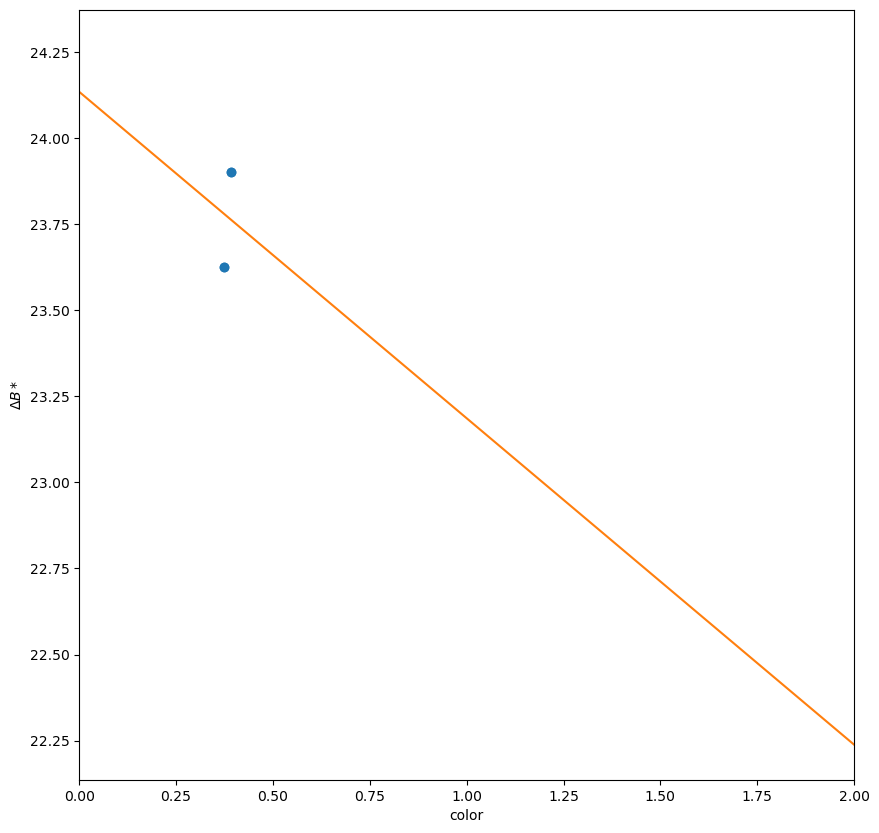

delta G* =  25.263 +/-   0.019 +  -0.817 +/-   0.060 color


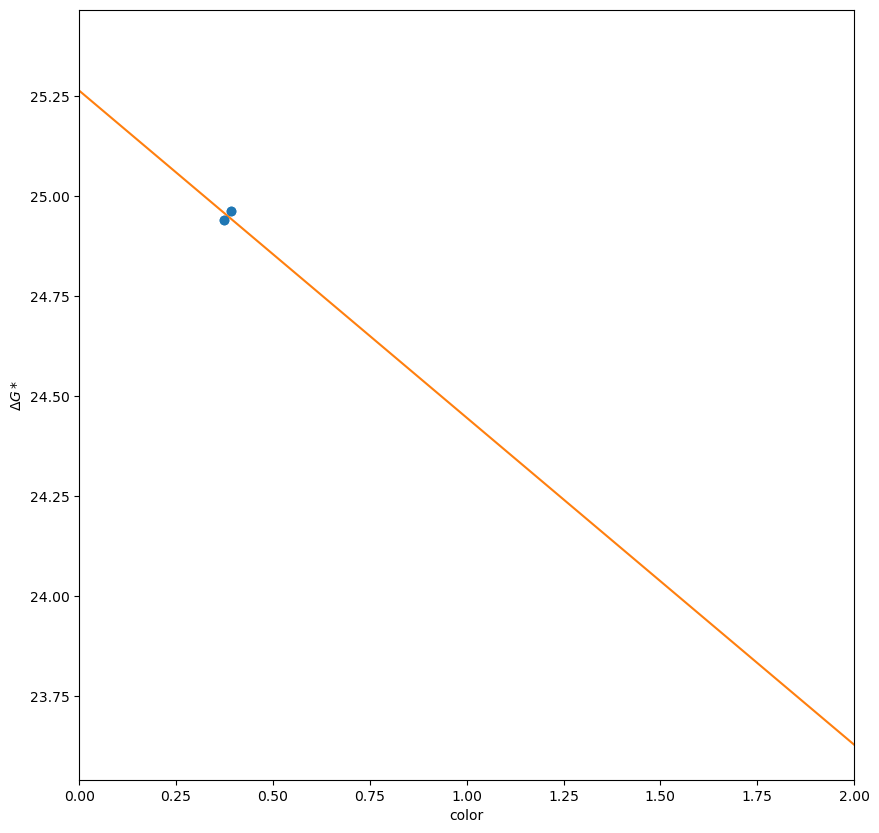

delta H_alpha =   5.492 +/-     nan +   2.060 +/-     nan color


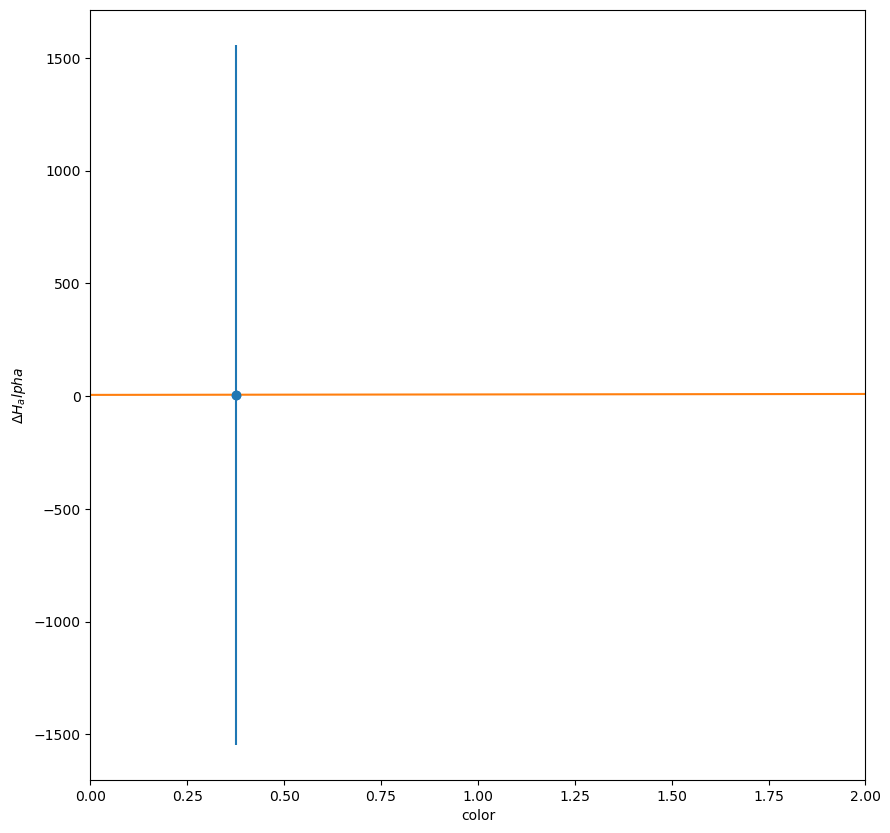

delta R* =  25.217 +/-   0.031 +   0.134 +/-   0.092 color


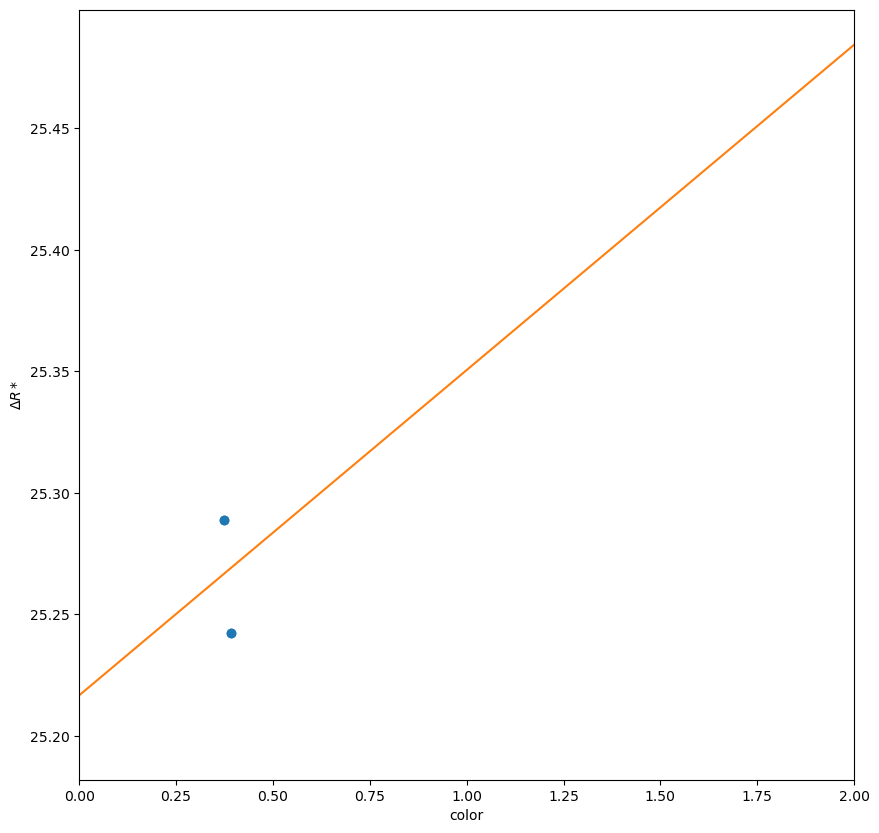

In [21]:
sols={}
for filt in phot_tables.keys():
    mask = np.logical_not(phot_tables[filt]['m{}'.format(filt)].mask) & np.greater(phot_tables[filt]['Nobs'],1)
    if filt == 'V':
        magtrue = np.array(np.compress(mask, phot_tables[filt]['V']))
        magdiff = (phot_tables[filt]['V']-phot_tables[filt]['m{}'.format(filt)]).compressed()
        color = np.array(np.compress(mask, phot_tables[filt]['B-V']))
    elif filt == 'B':
        magtrue = np.array(np.compress(mask, phot_tables[filt]['V']+phot_tables[filt]['B-V']))
        magdiff = (phot_tables[filt]['V']+phot_tables[filt]['B-V']-phot_tables[filt]['m{}'.format(filt)]).compressed()
        color = np.array(np.compress(mask, phot_tables[filt]['B-V']))
    else: #filt == 'R'
        magtrue = np.array(np.compress(mask, phot_tables[filt]['V']-phot_tables[filt]['V-R']))
        magdiff = (phot_tables[filt]['V']-phot_tables[filt]['V-R']-phot_tables[filt]['m{}'.format(filt)]).compressed()
        color = np.array(np.compress(mask, phot_tables[filt]['V-R']))
    sigma = phot_tables[filt]['e{}'.format(filt)].compressed()
    airmass = np.array(np.compress(mask, phot_tables[filt]['Airmass']))
    aircolor = color * airmass
    #print(filt,magdiff,magtrue,color,sigma,airmass,aircolor)
    
    # do the fitting
    y=magdiff
    basis=[]
    basis.append(np.ones(y.shape))
    basis.append(color)
    ## if you have enough data to measure the extinction corrections, uncomment the following two lines
    ## in that case, the sol and var arrays will have four entries, not two, and the inversion below requries a matrix inverstion
    #basis.append(airmass)
    #basis.append(aircolor)
    basis=np.transpose(np.array(basis))
    sol,var,chi2 = svdfit2(basis,y,sigma)
    #print(filt,sol,np.sqrt(var),chi2)
    print('delta {} = {:7.3f} +/- {:7.3f} + {:7.3f} +/- {:7.3f} color'.format(filt,sol[0],np.sqrt(var)[0],sol[1],np.sqrt(var)[1]))
    sols[filt]=sol
    
    # plot the fit result
    fig, ax = plt.subplots()
    ax.scatter(color,magdiff)
    #ax.set(xlim=(0.,2.),ylim=(21.5,19.5))
    ax.set(xlim=(0.,2.))
    ax.errorbar(color, magdiff, yerr=sigma, fmt='o')
    ax.set_xlabel(r'color')
    ax.set_ylabel(r'$\Delta {}$'.format(filt))
    x=np.arange(0,2.1,0.1)
    y=sol[0]+x*sol[1]
    ax.plot(x, y)
    plt.show()

In [23]:
import pandas as pd
df = pd.DataFrame.from_dict({k.rstrip('*'):{'ZP':v[0],'ct':v[1]} for k,v in sols.items()}, orient='index')
